# 1. Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import pickle
import requests
import io
from io import StringIO
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Leitura do arquivo extraído no site do ipea

In [2]:
url = 'https://drive.google.com/uc?id=1ilAXCcKolm_2WAVdiC_1ycQTq5zHMwhj'
response = requests.get(url)
response.raise_for_status()

In [3]:
df = pd.read_csv(StringIO(response.text), sep=';', decimal=',')
df = df.drop(df.columns[2], axis=1)
df.columns = ['DAT_MEDICAO', 'VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT']

# 3. Informações iniciais da base

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13768 entries, 0 to 13767
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DAT_MEDICAO                           13768 non-null  object 
 1   VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT  11348 non-null  float64
dtypes: float64(1), object(1)
memory usage: 215.3+ KB


# 4. Filtro do período a ser analisado e conversão da DAT_MEDICAO

In [5]:
df['DAT_MEDICAO'] = pd.to_datetime(df['DAT_MEDICAO'])
df = df[(df['DAT_MEDICAO'] >= '2020-01-01') & (df['DAT_MEDICAO'] <= '2024-12-31')].reset_index(drop=True)
df_tratado = df.copy()

/var/folders/0w/1tq6p0713v95vf0m1rn3k1600000gn/T/ipykernel_5159/1691056696.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DAT_MEDICAO'] = pd.to_datetime(df['DAT_MEDICAO'])


In [6]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   DAT_MEDICAO                           1827 non-null   datetime64[ns]
 1   VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT  1271 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


# 5. Análise e ajustes de dados ausentes

In [7]:
df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'].unique()

array([  nan, 67.05, 69.08, ..., 73.5 , 73.77, 74.58], shape=(1132,))

In [8]:
df_tratado['DAT_MEDICAO'].unique()

<DatetimeArray>
['2020-01-01 00:00:00', '2020-01-02 00:00:00', '2020-01-03 00:00:00',
 '2020-01-04 00:00:00', '2020-01-05 00:00:00', '2020-01-06 00:00:00',
 '2020-01-07 00:00:00', '2020-01-08 00:00:00', '2020-01-09 00:00:00',
 '2020-01-10 00:00:00',
 ...
 '2024-12-22 00:00:00', '2024-12-23 00:00:00', '2024-12-24 00:00:00',
 '2024-12-25 00:00:00', '2024-12-26 00:00:00', '2024-12-27 00:00:00',
 '2024-12-28 00:00:00', '2024-12-29 00:00:00', '2024-12-30 00:00:00',
 '2024-12-31 00:00:00']
Length: 1827, dtype: datetime64[ns]

In [9]:
df_tratado.loc[df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'].isna(), 'DAT_MEDICAO'].unique()

<DatetimeArray>
['2020-01-01 00:00:00', '2020-01-04 00:00:00', '2020-01-05 00:00:00',
 '2020-01-11 00:00:00', '2020-01-12 00:00:00', '2020-01-18 00:00:00',
 '2020-01-19 00:00:00', '2020-01-25 00:00:00', '2020-01-26 00:00:00',
 '2020-02-01 00:00:00',
 ...
 '2024-12-08 00:00:00', '2024-12-14 00:00:00', '2024-12-15 00:00:00',
 '2024-12-17 00:00:00', '2024-12-18 00:00:00', '2024-12-21 00:00:00',
 '2024-12-22 00:00:00', '2024-12-25 00:00:00', '2024-12-28 00:00:00',
 '2024-12-29 00:00:00']
Length: 556, dtype: datetime64[ns]

In [10]:
df_tratado = df_tratado.dropna().reset_index(drop=True)

In [12]:
df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'].unique()

array([67.05, 69.08, 70.25, ..., 73.5 , 73.77, 74.58], shape=(1131,))

# 6. Criação de novos campos e ordenação

In [13]:
df_tratado['DAT_MES_MEDICAO'] = df_tratado['DAT_MEDICAO'].dt.strftime('%Y-%m')
df_tratado['NUM_DIA_SEMANA'] = df_tratado['DAT_MEDICAO'].dt.dayofweek
df_tratado['NUM_DIA_MES'] = df_tratado['DAT_MEDICAO'].dt.day
df_tratado['NUM_ANO'] = df_tratado['DAT_MEDICAO'].dt.year
df_tratado = df_tratado[['DAT_MEDICAO', 'DAT_MES_MEDICAO', 'NUM_DIA_SEMANA', 'NUM_DIA_MES', 'NUM_ANO', 'VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT']]

# 7. Visualização dos dados tratados

In [15]:
df_tratado.head()

,DAT_MEDICAO,DAT_MES_MEDICAO,NUM_DIA_SEMANA,NUM_DIA_MES,NUM_ANO,VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT
0,2020-01-02,2020-01,3,2,2020,67.05
1,2020-01-03,2020-01,4,3,2020,69.08
2,2020-01-06,2020-01,0,6,2020,70.25
3,2020-01-07,2020-01,1,7,2020,68.74
4,2020-01-08,2020-01,2,8,2020,67.31


# 8. Análises gráficas

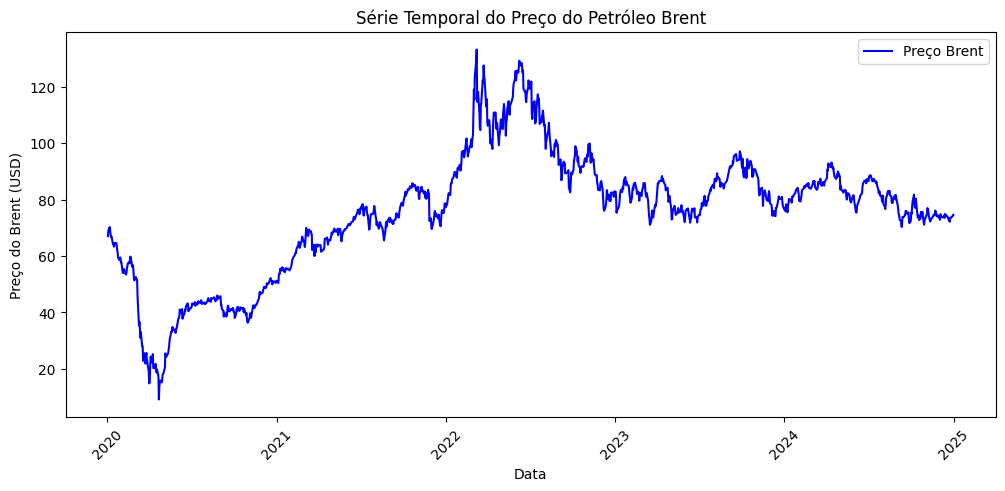

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"], label="Preço Brent", color='b')
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Série Temporal do Preço do Petróleo Brent")
plt.legend()
plt.xticks(rotation=45)
plt.show()

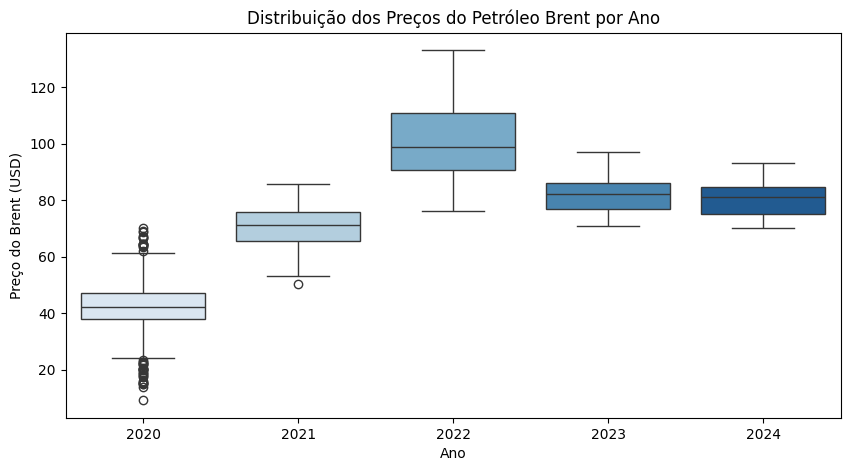

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_tratado["NUM_ANO"].astype(str),
            y=df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"],
            hue=df_tratado["NUM_ANO"].astype(str),
            palette="Blues",
            legend=False)

plt.xlabel("Ano")
plt.ylabel("Preço do Brent (USD)")
plt.title("Distribuição dos Preços do Petróleo Brent por Ano")
plt.show()

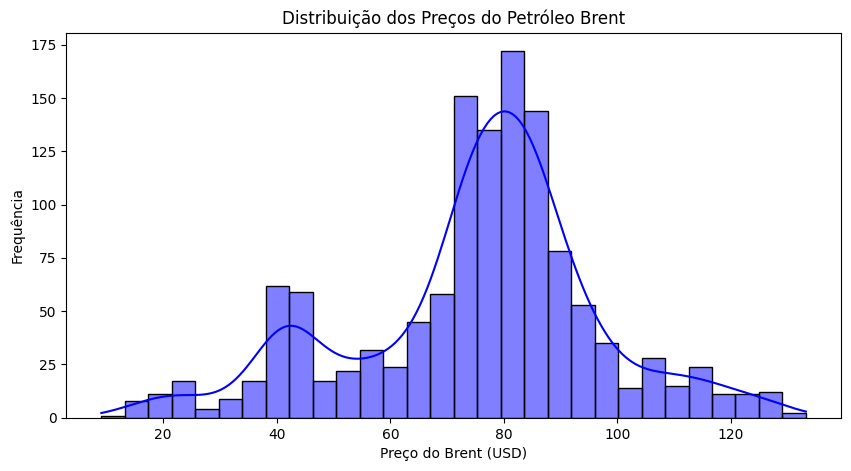

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"], bins=30, kde=True, color='b')
plt.xlabel("Preço do Brent (USD)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Preços do Petróleo Brent")
plt.show()

/var/folders/0w/1tq6p0713v95vf0m1rn3k1600000gn/T/ipykernel_5159/2062300024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tratado["Media_Movel_30d"] = df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"].rolling(window=30).mean()


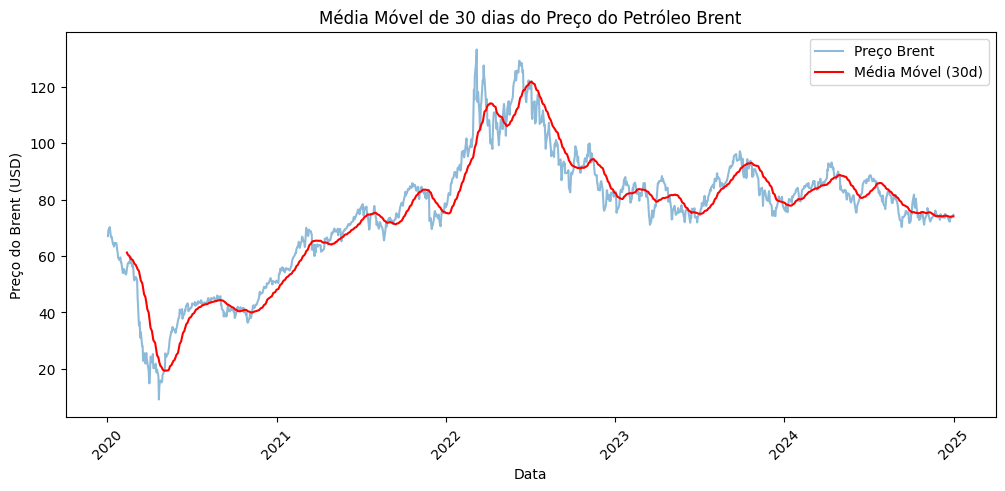

In [19]:
df_tratado["Media_Movel_30d"] = df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"].rolling(window=30).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"], label="Preço Brent", alpha=0.5)
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["Media_Movel_30d"], label="Média Móvel (30d)", color='r')
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Média Móvel de 30 dias do Preço do Petróleo Brent")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 9. Modelo SARIMAX

### Teste de estacionariedade (Dickey-Fuller)

In [20]:
def testar_estacionariedade(serie):
    resultado = adfuller(serie, autolag='AIC')
    print(f"Estatística de Teste: {resultado[0]}")
    print(f"Valor-p: {resultado[1]}")
    print("Valores Críticos:")
    for chave, valor in resultado[4].items():
        print(f"   {chave}: {valor}")
    if resultado[1] <= 0.05:
        print("\nA série é estacionária.")
    else:
        print("\nA série NÃO é estacionária. Aplicando diferenciação...")

testar_estacionariedade(df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'])

Estatística de Teste: -1.4456817574094845
Valor-p: 0.5601905394434206
Valores Críticos:
   1%: -3.4355340425478706
   5%: -2.863829299639741
   10%: -2.5679888467643406

A série NÃO é estacionária. Aplicando diferenciação...


In [21]:
df_tratado['d1'] = df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'].diff().dropna()

testar_estacionariedade(df_tratado['d1'].dropna())

Estatística de Teste: -16.5445394702388
Valor-p: 1.9700824788587625e-29
Valores Críticos:
   1%: -3.4355340425478706
   5%: -2.863829299639741
   10%: -2.5679888467643406

A série é estacionária.


/var/folders/0w/1tq6p0713v95vf0m1rn3k1600000gn/T/ipykernel_5159/1918077096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tratado['d1'] = df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'].diff().dropna()


### Gráficos de autocorrelação

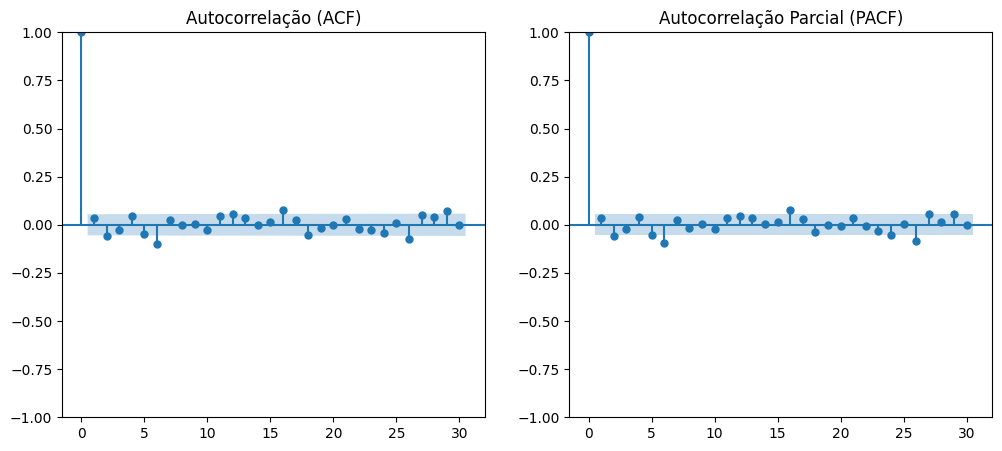

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_acf(df_tratado['d1'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelação (ACF)')

plt.subplot(122)
plot_pacf(df_tratado['d1'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelação Parcial (PACF)')

plt.show()

### Definicão dos parâmetros

In [23]:
modelo_sarima = SARIMAX(df_tratado['VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
ajuste_sarima = modelo_sarima.fit()

print(ajuste_sarima.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                         
Dep. Variable:     VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT   No. Observations:                 1271
Model:                   SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -2681.318
Date:                                  Mon, 17 Feb 2025   AIC                           5380.636
Time:                                          23:56:42   BIC                           5426.872
Sample:                                               0   HQIC                          5398.012
                                                 - 1271                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0947      0.217     -0.436      0.663      -0.520

### Previsões

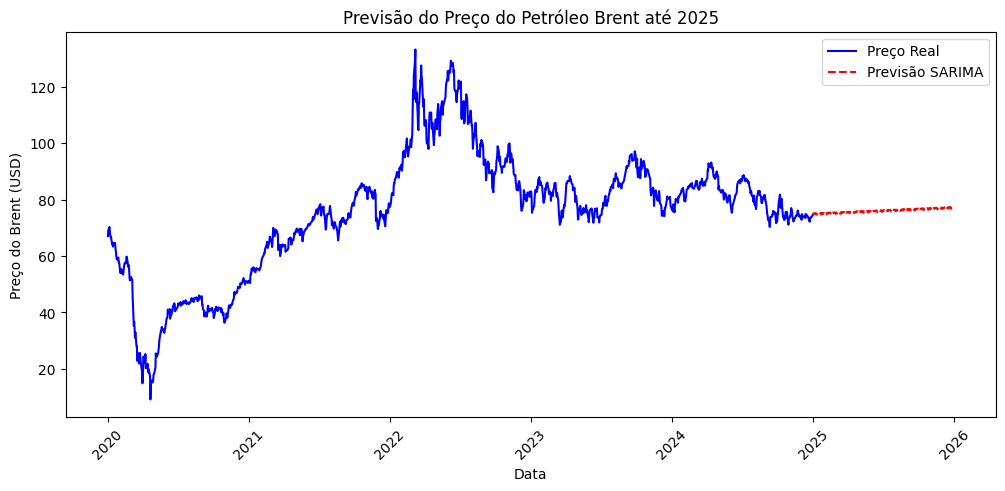

In [24]:
dias_prever = (pd.Timestamp("2025-12-31") - df_tratado["DAT_MEDICAO"].max()).days

previsoes_sarima = ajuste_sarima.forecast(steps=dias_prever)

datas_futuras = pd.date_range(start=df_tratado["DAT_MEDICAO"].max(), periods=dias_prever, freq='D')

df_previsao = pd.DataFrame({"DAT_MEDICAO": datas_futuras, "PREVISAO_BRENT": previsoes_sarima})

plt.figure(figsize=(12, 5))
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT"], label="Preço Real", color='blue')
plt.plot(df_previsao["DAT_MEDICAO"], df_previsao["PREVISAO_BRENT"], linestyle='dashed', color='red', label="Previsão SARIMA")
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Previsão do Preço do Petróleo Brent até 2025")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 10. Modelo PROPHET

23:56:56 - cmdstanpy - INFO - Chain [1] start processing
23:56:57 - cmdstanpy - INFO - Chain [1] done processing


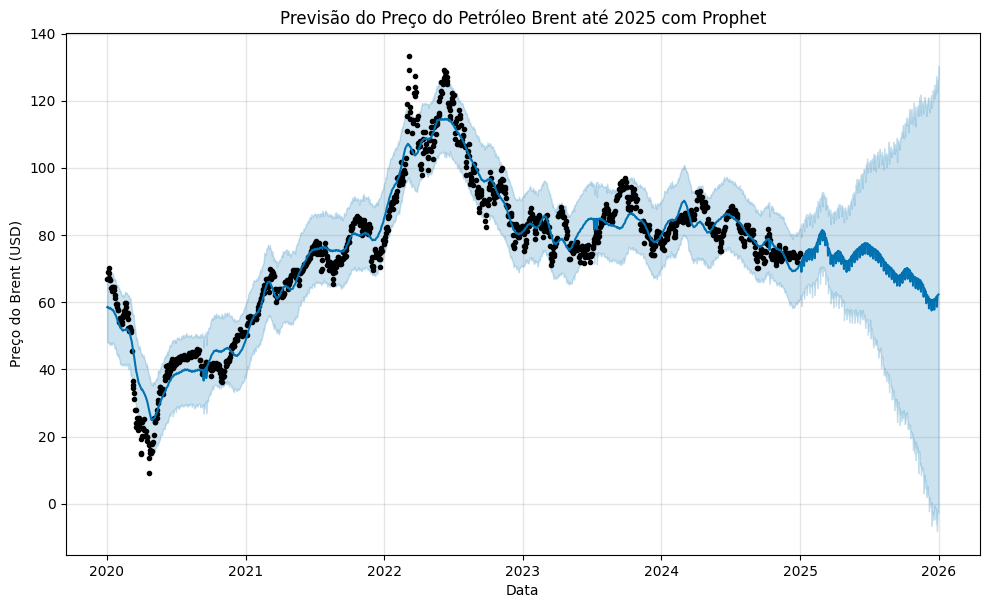

In [25]:
df_prophet = df_tratado[['DAT_MEDICAO', 'VLR_PRECO_PETROLEO_BRUTO_DOLAR_BRENT']]
df_prophet.columns = ['ds', 'y']

modelo_prophet = Prophet(interval_width=0.95)
modelo_prophet.fit(df_prophet)

future = modelo_prophet.make_future_dataframe(periods=(pd.Timestamp("2025-12-31") - df_prophet['ds'].max()).days, freq='D')
forecast = modelo_prophet.predict(future)

fig = modelo_prophet.plot(forecast)
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Previsão do Preço do Petróleo Brent até 2025 com Prophet")
plt.show()

### Salvar o arquivo no diretório atual

In [26]:
with open('modelo_prophet.pkl', 'wb') as f:
    pickle.dump(modelo_prophet, f)

### Leitura via GitHub e teste do modelo

In [27]:
url = 'https://raw.githubusercontent.com/Baaprado/Pos_Tech_FIAP_Fase_4/main/modelo_prophet.pkl'

response = requests.get(url)
response.raise_for_status()  

with io.BytesIO(response.content) as f:
    modelo_prophet = pickle.load(f)

future = modelo_prophet.make_future_dataframe(periods=365)

forecast = modelo_prophet.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds       yhat  yhat_lower  yhat_upper
1631 2025-12-27  58.643330   -7.247474  122.797974
1632 2025-12-28  61.455133   -6.331258  126.668839
1633 2025-12-29  62.049753   -2.639803  125.249119
1634 2025-12-30  62.210469   -1.038526  127.718322
1635 2025-12-31  62.308750   -6.420843  126.965939
